In [3]:
import torch
import torch.nn.functional as F
import requests
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [5]:
url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
res = requests.get(url)
full_text = res.text
words = full_text.splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [7]:
chars = sorted(list(set("".join(words))))
stoi = {char:i+1 for i, char in enumerate(chars)}
stoi["."] = 0
itos = {i:char for char, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [29]:
block_size = 3

def build_dataset(words):
    xs, ys = [], []
    
    for word in words:
        ctx = [0] * block_size
        for char in word + ".":
            ix = stoi[char]
            xs.append(ctx)
            ys.append(ix)
            ctx = ctx[1:] + [ix]
            
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

for i in range(5):
    example_x, example_y = Xtr[i], Ytr[i]
    output = ""
    for j in range(len(example_x)):
        output += itos[example_x[j].item()]
    print("Context:", output)
    print("Expected:", itos[example_y.item()])

torch.Size([182551, 3]) torch.Size([182551])
torch.Size([22783, 3]) torch.Size([22783])
torch.Size([22812, 3]) torch.Size([22812])
Context: ...
Expected: f
Context: ..f
Expected: a
Context: .fa
Expected: o
Context: fao
Expected: l
Context: aol
Expected: a


std must be 1/sqrt(fan_in)

In [167]:
n_embd = 10
n_hidden = 200

C = torch.randn(vocab_size, n_embd)
w1 = torch.randn(n_embd * block_size, n_hidden) * (5/3) / (n_embd * block_size)**0.5 
#b1 = torch.randn(n_hidden) * 0.01
w2 = torch.randn(n_hidden, vocab_size) / (n_hidden)**0.5
b2 = torch.randn(vocab_size) * 0.01

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = [C, w1, w2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [168]:
max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    xb, yb = Xtr[ix], Ytr[ix]

    emb = C[xb]
    embcat = emb.view(emb.shape[0], -1)
    # should be roughly gaussian
    hpreact = embcat @ w1 #+ b1
    # batchnorm layer
    # ------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ------------------------------------------------
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, yb)

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if step < 100000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr
    
    if step % 10000 == 0:
        print(f"step: {step} | loss: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    #break

step: 0 | loss: 3.4375
step: 10000 | loss: 2.3212
step: 20000 | loss: 1.9294
step: 30000 | loss: 2.3763
step: 40000 | loss: 2.3576
step: 50000 | loss: 1.9132
step: 60000 | loss: 2.0034
step: 70000 | loss: 2.4361
step: 80000 | loss: 1.8689
step: 90000 | loss: 2.0681
step: 100000 | loss: 1.8523
step: 110000 | loss: 1.8306
step: 120000 | loss: 2.0074
step: 130000 | loss: 2.1770
step: 140000 | loss: 2.3940
step: 150000 | loss: 2.4966
step: 160000 | loss: 2.1896
step: 170000 | loss: 2.1731
step: 180000 | loss: 1.9424
step: 190000 | loss: 2.2736


(array([454., 220., 175., 146., 141., 111., 118.,  96.,  75.,  78.,  94.,
         74., 102., 109.,  85.,  55., 114., 105.,  88.,  89., 130., 128.,
        135., 113., 112., 162.,  93.,  99., 120., 122., 102., 122., 105.,
         96.,  94., 104.,  97.,  91.,  91., 100.,  91.,  93.,  93., 109.,
        121., 138., 164., 172., 206., 468.]),
 array([-9.99967873e-01, -9.59968572e-01, -9.19969270e-01, -8.79969969e-01,
        -8.39970667e-01, -7.99971366e-01, -7.59972064e-01, -7.19972763e-01,
        -6.79973462e-01, -6.39974160e-01, -5.99974859e-01, -5.59975557e-01,
        -5.19976256e-01, -4.79976954e-01, -4.39977653e-01, -3.99978352e-01,
        -3.59979050e-01, -3.19979749e-01, -2.79980447e-01, -2.39981146e-01,
        -1.99981844e-01, -1.59982543e-01, -1.19983242e-01, -7.99839401e-02,
        -3.99846387e-02,  1.46627426e-05,  4.00139642e-02,  8.00132656e-02,
         1.20012567e-01,  1.60011868e-01,  2.00011170e-01,  2.40010471e-01,
         2.80009773e-01,  3.20009074e-01,  3.60008

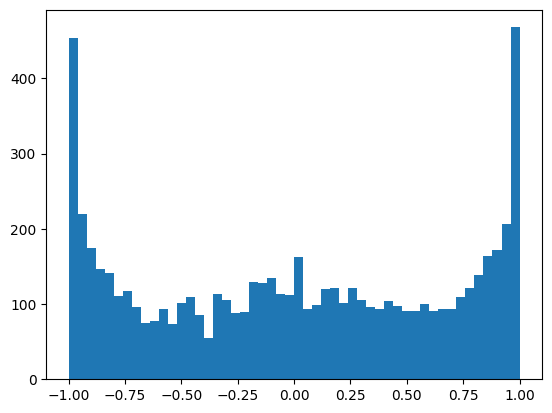

In [169]:
plt.hist(h.view(-1).tolist(), 50)

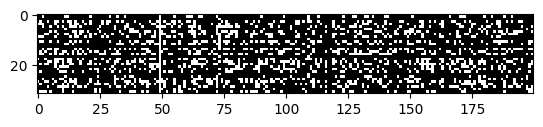

In [170]:
mask = h.abs() > 0.9
plt.imshow(mask, cmap="gray", interpolation='nearest')

In [171]:
logits[0]

tensor([-4.3155,  2.0501,  1.0225,  1.0608,  0.9629,  1.1260, -0.5641, -0.2474,
         0.0592, -0.5528,  1.2710,  1.3970,  1.1001,  1.4818,  0.5654, -0.2833,
        -0.3053, -2.1485,  0.6235,  1.0730,  0.9814, -1.7551, -0.6216, -1.2834,
        -1.9204, -0.2881,  0.7385], grad_fn=<SelectBackward0>)

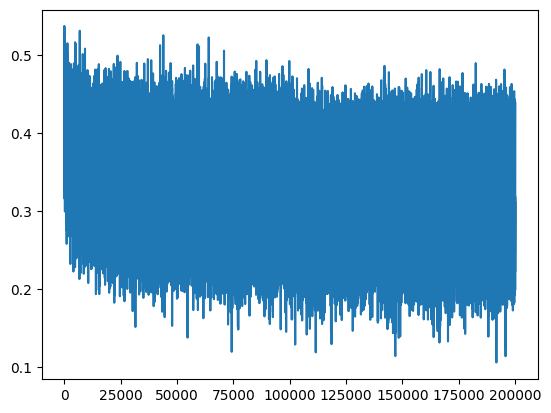

In [172]:
plt.plot(lossi)

In [173]:
# calibrate batch norm statistics at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [179]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = hpreact.tanh()
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0661025047302246
val 2.123345375061035


In [166]:
for i in range(20):
    name = ""
    ctx = [0] * block_size
    for x in range(30):
        ins = torch.tensor(ctx)
        emb = C[ins]
        embcat = emb.view(-1)
        hpreact = embcat @ w1 + b1
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
        h = hpreact.tanh()
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=-1)
        selected = torch.multinomial(probs, num_samples=1).item()
        ctx = ctx[1:] + [selected]
        name += itos[selected]
        if itos[selected] == ".":
            break
    print(name)

lucilve.
kyma.
juliel.
littorrsh.
jadiyomi.
amadrichia.
handayomirodalyannader.
tom.
tonyehaa.
ana.
cortelynn.
raatiiley.
jargan.
zulleriyan.
cobe.
yukiine.
anrodia.
keel.
naiyah.
joelynn.
